# Preprint Analysis
## How to get all preprints of a topics?

We use [OpenAlex](https://openalex.org) to retrieve all articles which are a preprint, but have so far not been published by a peer-reviewed journal.

## 1. Load libraries

In [1]:
!pip install pandas
!pip install pyalex
!pip install matplotlib

In [2]:
from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders
from itertools import chain
import pandas as pd
import pyalex
import os

## 1. Define helper functions

In [3]:
# Determine if any of the locations (journals) the paper is already published
def is_any_location_published(locations):
    for location in locations:
        if location['version'] == 'publishedVersion':
            return True
    return False

In [4]:
# Combine all authos
def join_authors(list_of_authors):
    return ', '.join([author['author']['display_name'] for author in list_of_authors])

In [5]:
# Extract key information from the locations
def join_locations(list_of_locations):
    summary = []
    for location in list_of_locations:
        if location['source']:
            summary.append(f"{location['version']}: {location['source']['host_organization_name']} - {location['landing_page_url']}")
        else:
            summary.append(f"{location['version']} - {location['landing_page_url']}")
    return ', '.join(summary)

In [6]:
def get_journal(primary_location):
    source = primary_location.get('source', {})
    if source:
        return source.get('display_name', '')
    return

## 2. Set the Topic & Year

Set the year and the number of papers you want to obtain

In [32]:
# Variables reduce the size of the output and the time required for execution
topic = 'COVID'
year = None
n_max = 500        # when set to None all papers are queried

## 3. Get the preprints

Run te following code to get the preprints for the specified parameters

In [31]:
# Query the 
if year:
    query = Works().search(topic).filter(type="article", publication_year=year, primary_location={'version': 'submittedVersion'}, locations={'is_published': False}).sort(cited_by_count="desc")
else:
    query = Works().search(topic).filter(type="article", primary_location={'version': 'submittedVersion'}, locations={'is_published': False}).sort(cited_by_count="desc")
    
    
preprints = []
keys = ['id', 'title', 'publication_date', 'doi', 'cited_by_count', 'language']

# Iterate over all query results
for item in chain(*query.paginate(per_page=200, n_max=n_max)):
    
    # Based on the published locations determine if it is a real preprint
    locations_count = item.get('locations_count', None)
    locations = item.get('locations', None)
    
    # Only append the paper to the preprints if is not published in any other journal
    if locations_count == 1 or not is_any_location_published(locations):
        # get all relevant properties
        properties = {key: item.get(key, None) for key in keys}
        # include joined authors and locations
        properties.update({'authors': join_authors(item['authorships']),
                           'locations': join_locations(item['locations']),
                           'journal': get_journal(item.get('primary_location', {})),
                           'location_count': locations_count})
        
        preprints.append(properties)


## 4. Process & store the data

In [9]:
df = pd.DataFrame.from_dict(preprints)
# Compute publication year
df['publication_year'] = df['publication_date'].str.split('-').str.get(0)
df

,id,title,publication_date,doi,cited_by_count,language,authors,locations,journal,location_count,publication_year
0,https://openalex.org/W3013515352,COVID-19 Screening on Chest X-ray Images Using...,2020-03-27,None,273,en,"Jianpeng Zhang, Yutong Xie, Yi Li, Chunhua She...",submittedVersion - https://europepmc.org/artic...,None,1,2020
1,https://openalex.org/W3009111036,Clinical Pathology of Critical Patient with No...,2020-02-27,None,138,en,"Weiren Luo, Hongjie Yu, Jizhou Gou, Xiaoxing L...",submittedVersion - http://rucweb.tsg211.com/ht...,None,1,2020
2,https://openalex.org/W3016112654,The COVID-19 risk perception: A survey on soci...,2020-03-21,https://doi.org/10.17632/wh9xk5mp9m.3,114,en,Toan Luu Duc Huynh,submittedVersion: Springer Nature - https://da...,Economics bulletin,1,2020
3,https://openalex.org/W3077072215,Undergraduate and Graduate Students' Mental He...,2020-08-17,None,105,en,"Igor Chirikov, Krista M. Soria, Bonnie Horgos,...",submittedVersion - https://escholarship.org/co...,None,1,2020
4,https://openalex.org/W3012039349,COVID-19: The First Public Coronavirus Twitter...,2020-03-16,None,101,en,"Emily Chen, Kristina Lerman, Emilio Ferrara",submittedVersion - https://europepmc.org/artic...,None,1,2020
...,...,...,...,...,...,...,...,...,...,...,...
582,https://openalex.org/W3107567267,Gendered Socio-economic Implications of the CO...,2020-01-01,None,3,en,"Emmanuel Ndhlovu, Archiford Tembo",submittedVersion - https://ideas.repec.org/a/r...,None,1,2020
583,https://openalex.org/W3108417454,SAÚDE DO IDOSO EM TEMPOS DE PANDEMIA COVID-19:...,2020-10-22,https://doi.org/10.5281/zenodo.4118417,3,en,"Maria Priscila Peixoto e Silva, Walquíria Lene...",submittedVersion: European Organization for Nu...,Zenodo (CERN European Organization for Nuclear...,1,2020
584,https://openalex.org/W3112705359,Price Discrimination-Driven Algorithmic Collus...,2020-09-24,None,3,en,Salil K. Mehra,submittedVersion: RELX Group (Netherlands) - h...,Social Science Research Network,1,2020
585,https://openalex.org/W3112719799,DESAFIOS DA IMPLEMENTAÇÃO DO ENSINO REMOTO,2020-11-04,https://doi.org/10.5281/zenodo.4252805,3,pt,"Dominique Guimarães de Souza, Jean Carlos Miranda",submittedVersion: European Organization for Nu...,Zenodo (CERN European Organization for Nuclear...,1,2020


In [10]:
# Store data as CSV file
os.makedirs('./results', exist_ok=True)
df.to_csv(f'./results/openalex_preprints_{year}_{n_max}.csv')

## 5. Get a sample paper

In [11]:
paper = df.iloc[0]
paper

id                                   https://openalex.org/W3013515352
title               COVID-19 Screening on Chest X-ray Images Using...
publication_date                                           2020-03-27
doi                                                              None
cited_by_count                                                    273
language                                                           en
authors             Jianpeng Zhang, Yutong Xie, Yi Li, Chunhua She...
locations           submittedVersion - https://europepmc.org/artic...
journal                                                          None
location_count                                                      1
publication_year                                                 2020
Name: 0, dtype: object

## 6. Basic analysis


In [27]:
import matplotlib.pyplot as plt


def plot_histogram(col, n=20):
    
    df['category'] = df[col].astype('category').cat.codes
    # Plot the histogram
    plt.hist(df['category'], bins=len(df[col].unique()), edgecolor='black', alpha=0.7)
    
    # Adding labels and title
    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of Categories {col}')

    # Adding x-ticks with original category names
    categories = df[col].astype('category').cat.categories
    plt.xticks(ticks=range(len(categories)), labels=categories, rotation=90)

In [35]:
df['publication_year'].value_counts()[:20]

publication_year
2020    440
2021    119
2022     21
2023      6
2018      1
Name: count, dtype: int64

In [ ]:
plot_histogram('publication_year')

In [34]:
df['journal'].value_counts()[:20]

journal
Social Science Research Network                                              135
Zenodo (CERN European Organization for Nuclear Research)                      73
arXiv (Cornell University)                                                    24
PubMed                                                                        20
Economic Bulletin Boxes                                                       17
MPRA Paper                                                                    16
FRB SF weekly letter                                                          10
medRxiv                                                                        9
Economics bulletin                                                             8
Choices                                                                        7
Liberty Street Economics                                                       7
Carolina Digital Repository (University of North Carolina at Chapel Hill)      7
BIS quarterly review

/home/natalie-widmann/Dokumente/Datenjournalismus/InvestigatingScience/research_recipes/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 152 (\x98) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/natalie-widmann/Dokumente/Datenjournalismus/InvestigatingScience/research_recipes/.venv/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Glyph 156 (\x9c) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/natalie-widmann/Dokumente/Datenjournalismus/InvestigatingScience/research_recipes/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 152 (\x98) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/natalie-widmann/Dokumente/Datenjournalismus/InvestigatingScience/research_recipes/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 156 (\x9c) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


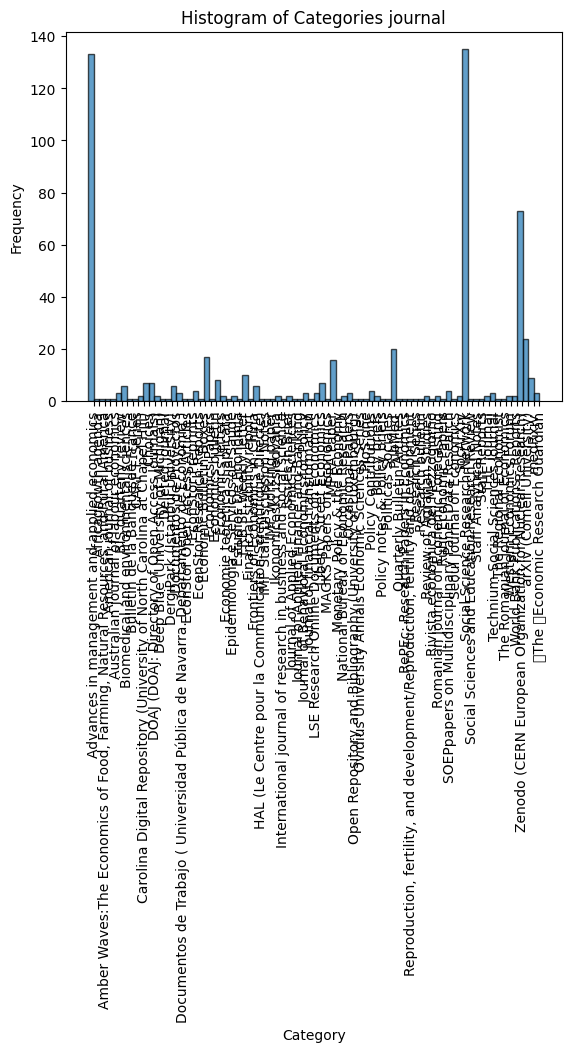

In [29]:
plot_histogram('journal')